<a href="https://colab.research.google.com/github/schumbar/CMPE258/blob/main/assignment_05/CMPE258_Assignment05_PartE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 05 Part E - Tensorflow
By Shawn Chumbar

## Assignment Guidelines
It is important to note that you will need to adhere to the following guidelines:
1. You must create a 3 layer neural network.
2. You must use einsum.
3. Use 3 variables based on non-linear equation.
4. Generate syntetic data using the equation you used and plot using 4-d plot in matplotlib.

## Assignment Description
Perform the following tasks:
1. Use Tensorflow various variants, including low-level API, API, functional, model, and built-in.
2. Use tensorflow from scratch.
3. Use tensorflow built-in layers.
4. Use tensorflow only with high-level API.

### References Used
1. [TensorFlow 2.0 + Keras Crash Course.ipynb - An end-to-end example: linear regression](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO?authuser=1#scrollTo=KC5RgwGeBP-9)

2. [TensorFlow 2.0 + Keras Crash Course.ipynb - Built-in layers](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO?authuser=1#scrollTo=WavMVtXGQk-z)

3. [TensorFlow 2.0 + Keras Crash Course.ipynb - A more Functional way of defining models](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO?authuser=1#scrollTo=SyC7KfV-YcYS)

4. [Intro to Keras for Researchers.ipynb](https://colab.research.google.com/drive/169PfzM0kvtA5UP4k6Sl1yCG9tsE2MLia?authuser=1#scrollTo=C_2FyZeXjHd1)

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions


### Generate Synthetic Data
The **generate_data()** function generates a 3 dimensional non-linear equation.

In [2]:
# Generate synthetic data using a 3D non-linear equation
def generate_data(num_samples):
    x1 = np.random.rand(num_samples)
    x2 = np.random.rand(num_samples)
    x3 = np.random.rand(num_samples)
    y = np.sin(2 * np.pi * x1) * np.cos(4 * np.pi * x2) * np.tanh(6 * np.pi * x3)
    return x1, x2, x3, y

### Plot 4-D Data
The **plot_4d_data()** function creates and displays a 4-dimensional plot of the data.

In [3]:
# Plot the 4D data using matplotlib
def plot_4d_data(x1, x2, x3, y):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(x1, x2, x3, c=y, cmap='viridis')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    fig.colorbar(p)
    plt.show()

### Create Model Functions
Below we have the **create_model()** functions pertaining to each problem type (i.e. from scratch, built-in layers, low-level API, and high-level API).

In [4]:
# Create the model using TensorFlow from scratch
def create_model_scratch(input_shape, hidden_sizes):
    weights = []
    biases = []

    prev_size = input_shape
    for hidden_size in hidden_sizes:
        weights.append(tf.Variable(tf.random.normal([prev_size, hidden_size], dtype=tf.float32)))
        biases.append(tf.Variable(tf.zeros([hidden_size], dtype=tf.float32)))
        prev_size = hidden_size

    weights.append(tf.Variable(tf.random.normal([prev_size, 1], dtype=tf.float32)))
    biases.append(tf.Variable(tf.zeros([1], dtype=tf.float32)))

    def model(x):
        hidden = x
        for i in range(len(hidden_sizes)):
            hidden = tf.einsum('bi,io->bo', hidden, weights[i]) + biases[i]
            hidden = tf.nn.relu(hidden)
        output = tf.einsum('bi,io->bo', hidden, weights[-1]) + biases[-1]
        return output

    model.weights = weights
    model.biases = biases

    return model

In [5]:
# Create the model using TensorFlow's built-in layers
def create_model_built_in_layers(input_shape):
    inputs = tf.keras.Input(shape=(input_shape,))

    layer1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
    layer2 = tf.keras.layers.Dense(32, activation='relu')(layer1)
    outputs = tf.keras.layers.Dense(1)(layer2)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Use einsum for matrix multiplication in the layers
    model.layers[1].call = lambda x: tf.einsum('bi,io->bo', x, model.layers[1].kernel) + model.layers[1].bias
    model.layers[2].call = lambda x: tf.einsum('bi,io->bo', x, model.layers[2].kernel) + model.layers[2].bias
    model.layers[3].call = lambda x: tf.einsum('bi,io->bo', x, model.layers[3].kernel) + model.layers[3].bias

    return model


In [6]:
# Create the model using TensorFlow's Low-Level API
def create_model_low_level(input_shape):
    inputs = tf.keras.Input(shape=(input_shape,))

    weights1 = tf.Variable(tf.random.normal([input_shape, 64]))
    biases1 = tf.Variable(tf.zeros([64]))
    layer1 = tf.nn.relu(tf.einsum('bi,io->bo', inputs, weights1) + biases1)

    weights2 = tf.Variable(tf.random.normal([64, 32]))
    biases2 = tf.Variable(tf.zeros([32]))
    layer2 = tf.nn.relu(tf.einsum('bi,io->bo', layer1, weights2) + biases2)

    weights3 = tf.Variable(tf.random.normal([32, 1]))
    biases3 = tf.Variable(tf.zeros([1]))
    outputs = tf.einsum('bi,io->bo', layer2, weights3) + biases3

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [7]:
# Create the model using TensorFlow's functional API and einsum
def create_model_high_level():
    inputs = tf.keras.layers.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Use einsum for matrix multiplication
    @tf.function
    def einsum_dense(inputs, weights, bias):
        return tf.einsum('bi,io->bo', inputs, weights) + bias

    model.layers[1].call = lambda x: einsum_dense(x, model.layers[1].kernel, model.layers[1].bias)
    model.layers[2].call = lambda x: einsum_dense(x, model.layers[2].kernel, model.layers[2].bias)

    return model

### Train Model Functions
Below we have the **train_model()** functions pertaining to each problem type (i.e. from scratch, built-in layers, low-level API, and high-level API).

In [8]:
def train_model_scratch(model, x_train, y_train, epochs, learning_rate):
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = tf.reduce_mean(tf.square(predictions - y))
        gradients = tape.gradient(loss, model.weights + model.biases)
        optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
        return loss

    for epoch in range(epochs):
        curr_loss = train_step(x_train, y_train)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {curr_loss:.4f}")

In [9]:
def train_model_built_in_layers(model, x_train, y_train, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(x_train, y_train, epochs=epochs, batch_size=32, verbose=1)

In [10]:
def train_model_low_level(model, x_train, y_train, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            labels = tf.cast(labels, tf.float32)  # Cast labels to float32
            loss = tf.reduce_mean(tf.square(predictions - labels))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    for epoch in range(epochs):
        curr_loss = train_step(x_train, y_train)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {curr_loss:.4f}")

In [11]:
def train_model_high_level(model, x_train, y_train, epochs):
  model.compile(optimizer='adam', loss='mse')
  model.fit(x_train, y_train, epochs=epochs, batch_size=32, verbose=1)

## Tensorflow from Scratch
The code below pertains to the "Tensorflow from Scratch" requirement.

### Generating Synthetic Data

In [12]:
# Generate synthetic data
num_samples = 1000
x1, x2, x3, y = generate_data(num_samples)
x_train = np.stack([x1, x2, x3], axis=1).astype(np.float32)
y_train = y.reshape(-1, 1).astype(np.float32)

### Creating Model

In [13]:
# Create the model
input_shape = 3
hidden_sizes = [64, 32]
model = create_model_scratch(input_shape, hidden_sizes)

### Training Model

In [14]:
# Train the model
epochs = 100
learning_rate = 0.01
train_model_scratch(model, x_train, y_train, epochs, learning_rate)

Epoch 0, Loss: 78.3758
Epoch 10, Loss: 8.9419
Epoch 20, Loss: 1.5425
Epoch 30, Loss: 1.2361
Epoch 40, Loss: 0.9717
Epoch 50, Loss: 0.6468
Epoch 60, Loss: 0.5198
Epoch 70, Loss: 0.4574
Epoch 80, Loss: 0.4066
Epoch 90, Loss: 0.3717


### Plotting Data

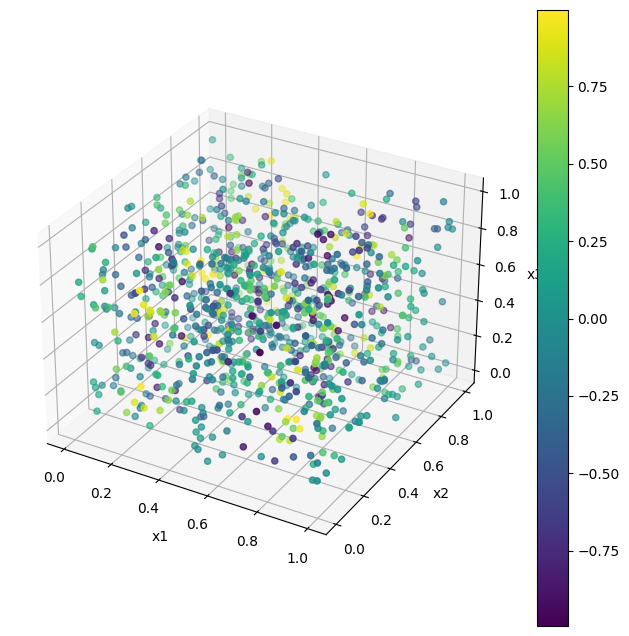

In [15]:
# Plot the 4D data
plot_4d_data(x1, x2, x3, y)

## Tensorflow Built-in Layers
The code below pertains to the "Built-in layers" requirement.

### Generating Synthetic Data

In [16]:
# Generate synthetic data
num_samples = 1000
x1, x2, x3, y = generate_data(num_samples)
x_train = np.stack([x1, x2, x3], axis=1)
y_train = y.reshape(-1, 1)

### Creating Model

In [17]:
# Create the model
input_shape = 3
model = create_model_built_in_layers(input_shape)

### Training Model

In [18]:
# Train the model
epochs = 100
train_model_built_in_layers(model, x_train, y_train, epochs)

Epoch 1/100
32/32 [==============================] - 5s 9ms/step - loss: 0.2624
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2353
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2419
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2362
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2380
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2345
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2352
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2363
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2351
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2347
Epoch 11/100
32/32 [==============================] - 0s 14ms/step - loss: 0.2345
Epoch 12/100
32/32 [==============================] - 0s 13ms/step - loss: 0.2339
Epoch 13/100
32/32 [===============

### Plotting Data

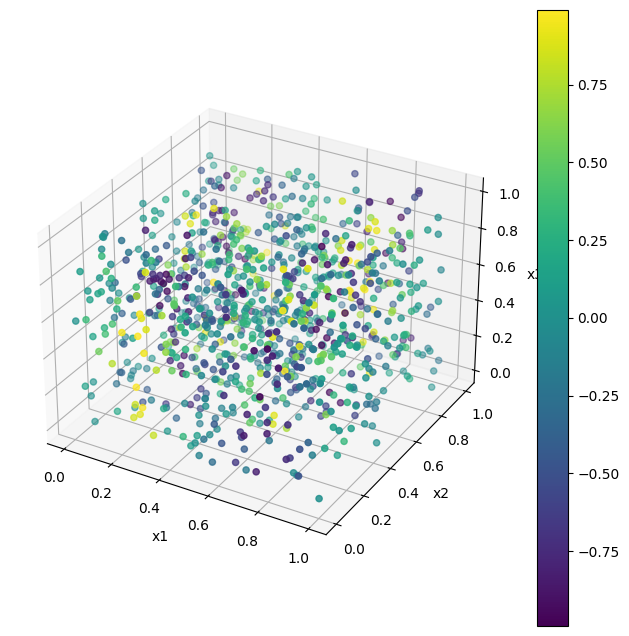

In [19]:
# Plot the 4D data
plot_4d_data(x1, x2, x3, y)

## Tensorflow Low-Level API
The code below pertains to the "Low-Level API" requirement.

### Generating Synthetic Data

In [20]:
# Generate synthetic data
num_samples = 1000
x1, x2, x3, y = generate_data(num_samples)
x_train = np.stack([x1, x2, x3], axis=1)
y_train = y.reshape(-1, 1)

### Creating Model

In [21]:
# Create the model
input_shape = 3
model = create_model_low_level(input_shape)

### Training Model

In [22]:
# Train the model
epochs = 100
train_model_low_level(model, x_train, y_train, epochs)

Epoch 0, Loss: 29.7526
Epoch 10, Loss: 29.7526
Epoch 20, Loss: 29.7526
Epoch 30, Loss: 29.7526
Epoch 40, Loss: 29.7526
Epoch 50, Loss: 29.7526
Epoch 60, Loss: 29.7526
Epoch 70, Loss: 29.7526
Epoch 80, Loss: 29.7526
Epoch 90, Loss: 29.7526


### Plotting Data

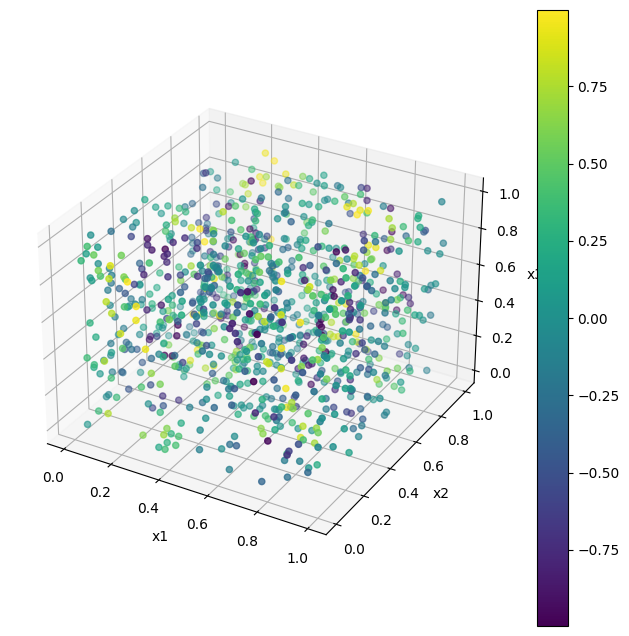

In [23]:
# Plot the 4D data
plot_4d_data(x1, x2, x3, y)

## Tensorflow High-level API
The code below pertains to the "Tensorflow High-Level API" requirement.

### Generating Synthetic Data

In [24]:
# Generate synthetic data
num_samples = 1000
x1, x2, x3, y = generate_data(num_samples)
x_train = np.stack([x1, x2, x3], axis=1)
y_train = y.reshape(-1, 1)

### Creating Model

In [25]:
# Create and train the model
model = create_model_high_level()

### Training Model

In [26]:
train_model_high_level(model, x_train, y_train, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 5ms/step - loss: 0.2618
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2436
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2439
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2455
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2453
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2421
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2491
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2435
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2473
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2443
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2433
Epoch 12/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2461
Epoch 13/100
32/32 [=================

### Plotting Data

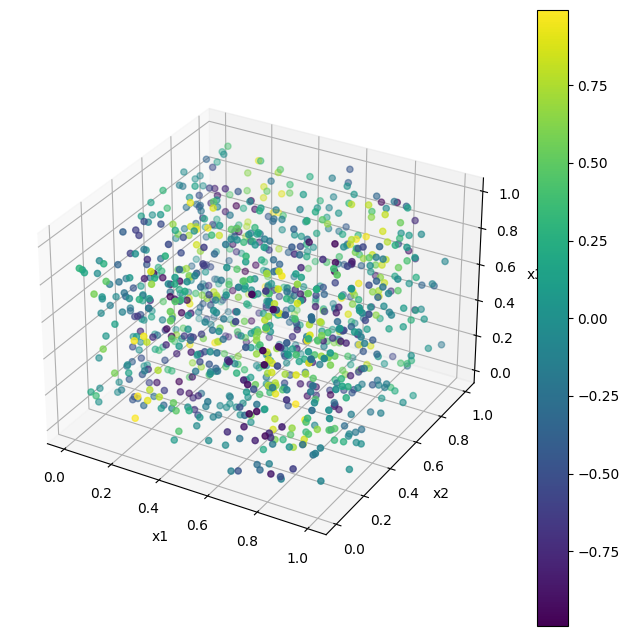

In [27]:
# Plot the 4D data
plot_4d_data(x1, x2, x3, y)